## 1. Introduction to Baby Names Data
<blockquote>
  <p>What’s in a name? That which we call a rose, By any other name would smell as sweet.</p>
</blockquote>
<p>In this project, we will explore a rich dataset of first names of babies born in the US, that spans a period of more than 100 years! This suprisingly simple dataset can help us uncover so many interesting stories, and that is exactly what we are going to be doing. </p>
<p>Let us start by reading the data.</p>

In [49]:
# Import modules
import pandas as pd

# Read names into a dataframe: bnames
bnames = pd.read_csv('datasets/names.csv.gz')
print(bnames.head())


        name sex  births  year
0       Mary   F    7065  1880
1       Anna   F    2604  1880
2       Emma   F    2003  1880
3  Elizabeth   F    1939  1880
4     Minnie   F    1746  1880


## 2. Exploring Trends in Names
<p>One of the first things we want to do is to understand naming trends. Let us start by figuring out the top five most popular male and female names for this decade (born 2011 and later). Do you want to make any guesses? Go on, be a sport!!</p>

In [77]:
# bnames_top5: A dataframe with top 5 popular male and female names for the decade

# First Step : deal with the filter - year

bnames_copy = bnames
bnames_copy = bnames_copy[bnames_copy['year'] > 2010]

del bnames_copy['year']

# Second Step : sort value

gb_df = bnames_copy.groupby(['sex','name'],as_index = False).sum()

gb_df_srt = gb_df.sort_values(by = ['sex','births'],ascending = False)
M_number = len(gb_df_srt.name[gb_df_srt['sex'] == 'M']) 

# Last Step : store the data for M & F and combine them together as bnames_top5

M_df_5 = gb_df_srt.iloc[0:5 , : ]
F_df_5 = gb_df_srt.iloc[M_number:M_number+5 , : ]

bnames_top5 = F_df_5.append(M_df_5)
bnames_top5 = bnames_top5.sort_values(by = 'sex', ascending = True)
print(bnames_top5)

      sex      name  births
52337   M      Zyus       5
9304    F      Emma  121375
26546   F    Sophia  117352
22720   F    Olivia  111691
11799   F  Isabella  103947
4124    F       Ava   94507
      sex      name  births
9304    F      Emma  121375
26546   F    Sophia  117352
22720   F    Olivia  111691
11799   F  Isabella  103947
4124    F       Ava   94507
52337   M      Zyus       5
46014   M      Noah  110280
44593   M     Mason  105104
38946   M     Jacob  104722
43724   M      Liam  103250
51129   M   William   99144


## 3. Proportion of Births
<p>While the number of births is a useful metric, making comparisons across years becomes difficult, as one would have to control for population effects. One way around this is to normalize the number of births by the total number of births in that year.</p>

In [51]:
# Compute the proportion of births by year and add it as a new column

# First Step : Do the Groupby to sum up the births by year

bnames2 = bnames.copy() # 1891893 rows

bnames2_bsum = bnames2.groupby('year',as_index = False)['births'].sum()
bnames2['prop_births'] = 0
bnames2['mbir_sum'] = 0

# Second Step : add sum of births into the DF as a new column and count the propotion

year_list = bnames2_bsum.year.values
for i in year_list:
    bir_sum = int(bnames2_bsum['births'][bnames2_bsum.year == i].values)
    bnames2.loc[bnames['year'] == i, 'mbir_sum'] = bir_sum # Note
    
bnames2['prop_births'] = bnames2['births'] / bnames2['mbir_sum']

# Last Step : delete the sum column and print the result

del bnames2['mbir_sum']
print(bnames2.head(5), '\n' ,bnames2.tail(5))


        name sex  births  year  prop_births
0       Mary   F    7065  1880     0.035065
1       Anna   F    2604  1880     0.012924
2       Emma   F    2003  1880     0.009941
3  Elizabeth   F    1939  1880     0.009624
4     Minnie   F    1746  1880     0.008666 
            name sex  births  year  prop_births
1891889  Zolton   M       5  2016     0.000001
1891890  Zurich   M       5  2016     0.000001
1891891  Zyahir   M       5  2016     0.000001
1891892    Zyel   M       5  2016     0.000001
1891893   Zylyn   M       5  2016     0.000001


## 4. Popularity of Names
<p>Now that we have the proportion of births, let us plot the popularity of a name through the years. How about plotting the popularity of the female names <code>Elizabeth</code>, and <code>Deneen</code>, and inspecting the underlying trends for any interesting patterns!</p>

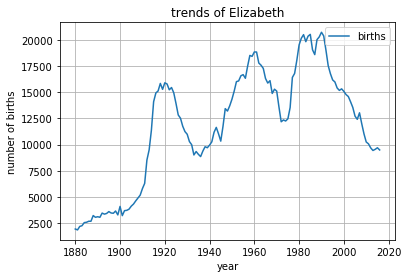

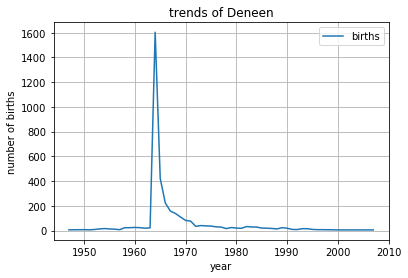

In [52]:
# First Step : Set up matplotlib for plotting in the notebook.

%matplotlib inline
import matplotlib.pyplot as plt

# Second Step : define new function 'plot_trends' to show trends of names

def plot_trends(name, sex):
    DF_a = bnames.loc[bnames['name'] == name]
    DF_b = DF_a.loc[DF_a['sex'] == sex]
    plt.plot(DF_b['year'],DF_b['births'])
    plt.legend(loc = 'upper right')
    plt.title('trends of '+name)
    plt.grid()
    plt.ylabel('number of births')
    plt.xlabel('year')
    return plt.show()

# Last Step : Plot trends for Elizabeth and Deneen and give the peak

plot_trends('Elizabeth', 'F')
plot_trends('Deneen', 'F')

num_peaks_elizabeth = 3
num_peaks_deneen = 1

## 5. Trendy vs. Stable Names
<p>Based on the plots we created earlier, we can see that <strong>Elizabeth</strong> is a fairly stable name, while <strong>Deneen</strong> is not. An interesting question to ask would be what are the top 5 stable and top 5 trendiest names. A stable name is one whose proportion across years does not vary drastically, while a trendy name is one whose popularity peaks for a short period and then dies down. </p>
<p>There are many ways to measure trendiness. A simple measure would be to look at the maximum proportion of births for a name, normalized by the sume of proportion of births across years. For example, if the name <code>Joe</code> had the proportions <code>0.1, 0.2, 0.1, 0.1</code>, then the trendiness measure would be <code>0.2/(0.1 + 0.2 + 0.1 + 0.1)</code> which equals <code>0.5</code>.</p>
<p>Let us use this idea to figure out the top 10 trendy names in this data set, with at least a 1000 births.</p>

In [53]:
# First Step : Get the max and total value

b_m = bnames.groupby(['sex','name'],as_index = False)['births'].max().rename(columns={'births':'max'})
b_s = bnames.groupby(['sex','name'],as_index = False)['births'].sum().rename(columns={'births':'total'})

# Second Step : merge the dataframe and count the % of trendiness

top10_trendy_names = pd.merge(b_m, b_s, how = 'left')

# top10_trendy_names | A Data Frame of the top 10 most trendy names

top10_trendy_names = top10_trendy_names[top10_trendy_names.total >= 1000]
top10_trendy_names['trendiness'] = top10_trendy_names['max'] / top10_trendy_names['total']

# Last Step : put the columns in the right order

top10_trendy_names = top10_trendy_names.sort_values(by = ['trendiness','max','name'], ascending = [False ,False, True])
top10_trendy_names = top10_trendy_names[:10]
cols = ['name', 'sex', 'total', 'max', 'trendiness']
top10_trendy_names = top10_trendy_names[cols]
top10_trendy_names = top10_trendy_names.reset_index(drop=True)

print(top10_trendy_names.head(10))

       name sex  total   max  trendiness
0  Christop   M   1082  1082    1.000000
1   Royalty   F   1057   581    0.549669
2     Kizzy   F   2325  1116    0.480000
3    Aitana   F   1203   564    0.468828
4    Deneen   F   3602  1604    0.445308
5    Moesha   F   1067   426    0.399250
6    Marely   F   2527  1004    0.397309
7     Kanye   M   1304   507    0.388804
8  Tennille   F   2172   769    0.354052
9   Kadijah   F   1411   486    0.344437


## 6. Bring in Mortality Data
<p>So, what more is in a name? Well, with some further work, it is possible to predict the age of a person based on the name (Whoa! Really????). For this, we will need actuarial data that can tell us the chances that someone is still alive, based on when they were born. Fortunately, the <a href="https://www.ssa.gov/">SSA</a> provides detailed <a href="https://www.ssa.gov/oact/STATS/table4c6.html">actuarial life tables</a> by birth cohorts.</p>
<table>
<thead>
<tr>
<th style="text-align:right;">year</th>
<th style="text-align:right;">age</th>
<th style="text-align:right;">qx</th>
<th style="text-align:right;">lx</th>
<th style="text-align:right;">dx</th>
<th style="text-align:right;">Lx</th>
<th style="text-align:right;">Tx</th>
<th style="text-align:right;">ex</th>
<th style="text-align:left;">sex</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:right;">1910</td>
<td style="text-align:right;">39</td>
<td style="text-align:right;">0.00283</td>
<td style="text-align:right;">78275</td>
<td style="text-align:right;">222</td>
<td style="text-align:right;">78164</td>
<td style="text-align:right;">3129636</td>
<td style="text-align:right;">39.98</td>
<td style="text-align:left;">F</td>
</tr>
<tr>
<td style="text-align:right;">1910</td>
<td style="text-align:right;">40</td>
<td style="text-align:right;">0.00297</td>
<td style="text-align:right;">78053</td>
<td style="text-align:right;">232</td>
<td style="text-align:right;">77937</td>
<td style="text-align:right;">3051472</td>
<td style="text-align:right;">39.09</td>
<td style="text-align:left;">F</td>
</tr>
<tr>
<td style="text-align:right;">1910</td>
<td style="text-align:right;">41</td>
<td style="text-align:right;">0.00318</td>
<td style="text-align:right;">77821</td>
<td style="text-align:right;">248</td>
<td style="text-align:right;">77697</td>
<td style="text-align:right;">2973535</td>
<td style="text-align:right;">38.21</td>
<td style="text-align:left;">F</td>
</tr>
<tr>
<td style="text-align:right;">1910</td>
<td style="text-align:right;">42</td>
<td style="text-align:right;">0.00332</td>
<td style="text-align:right;">77573</td>
<td style="text-align:right;">257</td>
<td style="text-align:right;">77444</td>
<td style="text-align:right;">2895838</td>
<td style="text-align:right;">37.33</td>
<td style="text-align:left;">F</td>
</tr>
<tr>
<td style="text-align:right;">1910</td>
<td style="text-align:right;">43</td>
<td style="text-align:right;">0.00346</td>
<td style="text-align:right;">77316</td>
<td style="text-align:right;">268</td>
<td style="text-align:right;">77182</td>
<td style="text-align:right;">2818394</td>
<td style="text-align:right;">36.45</td>
<td style="text-align:left;">F</td>
</tr>
<tr>
<td style="text-align:right;">1910</td>
<td style="text-align:right;">44</td>
<td style="text-align:right;">0.00351</td>
<td style="text-align:right;">77048</td>
<td style="text-align:right;">270</td>
<td style="text-align:right;">76913</td>
<td style="text-align:right;">2741212</td>
<td style="text-align:right;">35.58</td>
<td style="text-align:left;">F</td>
</tr>
</tbody>
</table>
<p>You can read the <a href="https://www.ssa.gov/oact/NOTES/as120/LifeTables_Body.html">documentation for the lifetables</a> to understand what the different columns mean. The key column of interest to us is <code>lx</code>, which provides the number of people born in a <code>year</code> who live upto a given <code>age</code>. The probability of being alive can be derived as <code>lx</code> by 100,000. </p>
<p>Given that 2016 is the latest year in the baby names dataset, we are interested only in a subset of this data, that will help us answer the question, "What percentage of people born in Year X are still alive in 2016?" </p>
<p>Let us use this data and plot it to get a sense of the mortality distribution!</p>

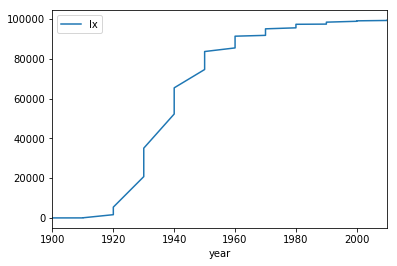

In [54]:
# First Step : Read lifetables from datasets/lifetables.csv
lifetables = pd.read_csv('datasets/lifetables.csv')

# Second Step : Extract subset relevant to those alive in 2016

lifetables['criteria'] = lifetables['year'] + lifetables['age']
lifetables_2016 = lifetables[lifetables.criteria == 2016]
del lifetables_2016['criteria']
lifetables_2016 = lifetables_2016.sort_values(by=['year','age'], ascending = [True, False])

# Last Step : Plot the mortality distribution: year vs. lx

lifetables_2016.plot(x = 'year', y = 'lx')
plt.show()

## 7. Smoothen the Curve!
<p>We are almost there. There is just one small glitch. The cohort life tables are provided only for every decade. In order to figure out the distribution of people alive, we need the probabilities for every year. One way to fill up the gaps in the data is to use some kind of interpolation. Let us keep things simple and use linear interpolation to fill out the gaps in values of <code>lx</code>, between the years <code>1900</code> and <code>2016</code>.</p>

In [55]:
# First Step : create a list contains the number of year

year_list = list(range(1900,2016))

# Second Step : create F & M dataframes with required data respectively

lifetable_n_2016_F = lifetables_2016[['year','lx']][lifetables_2016.sex == 'F'] #.sort_values(by =['year','lx'],ascending = [True, True])
lifetable_n_2016_M = lifetables_2016[['year','lx']][lifetables_2016.sex == 'M'] #.sort_values(by =['year','lx'],ascending = [True, True])

# Third Step : interpolate and reindex

lifetable_n_2016_F = lifetable_n_2016_F.set_index('year').reindex(year_list).interpolate()
lifetable_n_2016_F['sex'] = 'F'
lifetable_n_2016_F['year'] = lifetable_n_2016_F.index

lifetable_n_2016_M = lifetable_n_2016_M.set_index('year').reindex(year_list).interpolate()
lifetable_n_2016_M['sex'] = 'M'
lifetable_n_2016_M['year'] = lifetable_n_2016_M.index

# Last Step : combine 2 dataframes together

lifetable_2016_s = lifetable_n_2016_F.append(lifetable_n_2016_M, ignore_index = True)
print(lifetable_2016_s.head())

     lx sex  year
0   0.0   F  1900
1   6.1   F  1901
2  12.2   F  1902
3  18.3   F  1903
4  24.4   F  1904


## 8. Distribution of People Alive by Name
<p>Now that we have all the required data, we need a few helper functions to help us with our analysis. </p>
<p>The first function we will write is <code>get_data</code>,which takes <code>name</code> and <code>sex</code> as inputs and returns a data frame with the distribution of number of births and number of people alive by year.</p>
<p>The second function is <code>plot_name</code> which accepts the same arguments as <code>get_data</code>, but returns a line plot of the distribution of number of births, overlaid by an area plot of the number alive by year.</p>
<p>Using these functions, we will plot the distribution of births for boys named <strong>Joseph</strong> and girls named <strong>Brittany</strong>.</p>

/Users/GT/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


         name sex  births  year   lx   n_alive
54495  Joseph   M    3714  1900  0.0  0.000000
57943  Joseph   M    2766  1901  0.7  0.019362
61196  Joseph   M    3098  1902  1.4  0.043372
64598  Joseph   M    3121  1903  2.1  0.065541
68070  Joseph   M    3291  1904  2.8  0.092148


/Users/GT/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


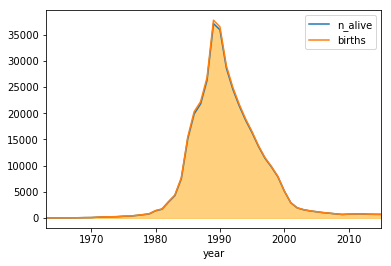

None


In [56]:
# First Step : Define get_data: takes name and sex as inputs and returns a data frame with the distribution of number of births and number of people alive by year

def get_data(name, sex):
    # lifetable_2016_s + bnames
    df = pd.merge(bnames, lifetable_2016_s, how = 'outer')
    # n_alive = lx * births / 100000
    df['n_alive'] = df['lx'] * df['births'] / 100000
    df_n = df[df.name == name]
    df_ns = df_n[df.sex == sex]
    df_ns = df_ns.dropna(how = 'any')

    return df_ns

print(get_data('Joseph', 'M').head(5))

# Second Step : Define plot_data: accepts the same arguments as get_data, but returns a line plot of the distribution of number of births, overlaid by an area plot of the number alive by year.

def plot_data(name, sex):
    # lifetable_2016_s + bnames
    df = pd.merge(bnames, lifetable_2016_s, how = 'outer')
    # n_alive = lx * births / 100000
    df['n_alive'] = df['lx'] * df['births'] / 100000
    df_n = df[df.name == name]
    df_ns = df_n[df.sex == sex]
    df_ns = df_ns.dropna(how = 'any')
    _ = df_ns.plot('year', ['n_alive', 'births'])
    _ = plt.fill_between(df_ns.year, df_ns.n_alive, color = 'orange',alpha=0.5)
    _ = plt.legend(loc = 'upper right')
    return plt.show()
    
# Last Step : Plot the distribution of births and number alive for Joseph and Brittany

print(plot_data('Brittany', 'F'))

## 9. Estimate Age
<p>In this section, we want to figure out the probability that a person with a certain name is alive, as well as the quantiles of their age distribution. In particular, we will estimate the age of a female named <strong>Gertrude</strong>. Any guesses on how old a person with this name is? How about a male named <strong>William</strong>?</p>

In [57]:
# Import modules
from wquantiles import quantile

# Function to estimate age quantiles
def estimate_age(name, sex):
    data = get_data(name, sex)
    q = [0.25, 0.5, 0.75]
    quantiles = [2016 - int(quantile(data.year, data.n_alive, i)) for i in q]
    q75, q50, q25 = quantiles
    p_alive = round(data.n_alive.sum() / data.births.sum(),3)
    outp = {'name' : name, 'sex' : sex, 'q25' : q25, 'q50' : q50, 'q75' : q75, 'p_alive':p_alive}
    outp = pd.Series(outp)
    return outp

# Estimate the age of Gertrude
print(estimate_age('Gertrude', 'F'))

# Estimate the age of William
print(estimate_age('William', 'M'))

/Users/GT/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


name       Gertrude
p_alive       0.187
q25              70
q50              80
q75              89
sex               F
dtype: object
name       William
p_alive      0.613
q25             31
q50             52
q75             66
sex              M
dtype: object


## 10. Median Age of Top 10 Female Names
<p>In the previous section, we estimated the age of a female named Gertrude. Let's go one step further this time, and compute the 25th, 50th and 75th percentiles of age, and the probability of being alive for the top 10 most common female names of all time. This should give us some interesting insights on how these names stack up in terms of median ages!</p>

In [80]:
# Purpose : Create median_ages: DataFrame with Top 10 Female names, age percentiles and probability of being alive

# First Step : get a list of top 10 Female names of all time (F_df_10)

F_df_10 = gb_df_srt.iloc[M_number:M_number+10 , : ]

# Second Step : use function 'estimate_age' to get the correct output (median_ages)

median_ages = [estimate_age(x, 'F') for x in F_df_10.name]
median_ages = pd.DataFrame(median_ages).sort_values(by = 'q50').reset_index(drop = True)

print(median_ages)

/Users/GT/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


        name  p_alive  q25  q50  q75 sex
0     Sophia    0.954    5    8   14   F
1   Isabella    0.974    5    8   12   F
2        Ava    0.971    4    8   11   F
3        Mia    0.990    4    9   13   F
4       Emma    0.768    6   12   19   F
5     Olivia    0.956    6   12   19   F
6    Abigail    0.987    7   13   19   F
7    Madison    0.992    8   13   17   F
8      Emily    0.926   12   20   29   F
9  Elizabeth    0.745   23   38   58   F
